In [66]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import metpy
from metpy.calc.tools import log_interp
#from matplotlib.colors import Normalize, LinearSegmentedColormap
#from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset
import netCDF4
from netCDF4 import num2date, date2num
import datetime
#import math
#import metpy
#import metpy.calc as metcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from wrf import getvar, ALL_TIMES
from wrf import to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from metpy.units import units
from metpy.calc import get_layer, get_wind_dir
#import wrf

In [67]:
#file_wrf = "/archive/archivedata/data_kevin/mwilso14/wrfout_d01_2016-08-24_12_YSUtest"
#file_wrf = "/archive/archivedata/data_kevin/mwilso14/wrfout_d02_2017-02-28_00:00:00"
#file_wrf = "/archive/archivedata/data_kevin/mwilso14/wrfout_d02_2017-03-30_00:00:00"
#file_wrf = "/archive/archivedata/data_kevin/mwilso14/wrfout_d02_1980-06-03_12:00:00"
#file_wrf = "/archive/archivedata/data_kevin/mwilso14/wrfout_d02_2017-05-10_00:00:00"
file_wrf = "wrfout_d02_1980-06-03_12"
WRF_out = Dataset(file_wrf)
print(WRF_out.variables)
ncfile = Dataset(file_wrf)

OrderedDict([(u'Times', <type 'netCDF4._netCDF4.Variable'>
|S1 Times(Time, DateStrLen)
unlimited dimensions: Time
current shape = (19, 19)
filling off
), (u'XLAT', <type 'netCDF4._netCDF4.Variable'>
float32 XLAT(Time, south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    description: LATITUDE, SOUTH IS NEGATIVE
    units: degree_north
    stagger: 
    coordinates: XLONG XLAT
unlimited dimensions: Time
current shape = (19, 150, 150)
filling off
), (u'XLONG', <type 'netCDF4._netCDF4.Variable'>
float32 XLONG(Time, south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    description: LONGITUDE, WEST IS NEGATIVE
    units: degree_east
    stagger: 
    coordinates: XLONG XLAT
unlimited dimensions: Time
current shape = (19, 150, 150)
filling off
), (u'LU_INDEX', <type 'netCDF4._netCDF4.Variable'>
float32 LU_INDEX(Time, south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    description: LAND USE CATEGORY
    units: 
    stagger: 
    coordinates: XLONG X

In [68]:
#read in some data
temp2 = np.float64(WRF_out.variables['T2'][:])
pot2 = np.float64(WRF_out.variables['TH2'][:])
sfcp = WRF_out.variables['PSFC'][:]/100.0
U = WRF_out.variables['U10'][:]
V = WRF_out.variables['V10'][:]
Uc = WRF_out.variables['U'][:]
Vc = WRF_out.variables['V'][:]
HGT = WRF_out.variables['HGT'][:]
#Use the height to calculate mslp
mslp = sfcp*(1-((.0065*HGT)/(temp2+(.0065*HGT))))**(-5.257)
clats = WRF_out.variables['XLAT'][:]
clons = WRF_out.variables['XLONG'][:]
clats = clats[0,:,:]
clons = clons[0,:,:]
#lats = WRF_out.variables[dlat][:]
#lons = WRF_out.variables[dlon][:]
#Use wrf python to read things in
slp = getvar(ncfile, "slp", timeidx=ALL_TIMES)
u_helicity = getvar(ncfile, "updraft_helicity", timeidx=ALL_TIMES)
dbz = getvar(ncfile, "dbz", timeidx=ALL_TIMES)
helicity = getvar(ncfile, "helicity", timeidx=ALL_TIMES, top = 3000)
helicity3 = getvar(ncfile, "helicity", timeidx=ALL_TIMES, top = 3000.0)
helicity15 = getvar(ncfile, "helicity", timeidx=ALL_TIMES, top = 1500.0)

ir_sat = getvar(ncfile, "ctt", timeidx=ALL_TIMES)
mcape = getvar(ncfile, "cape_2d", timeidx=ALL_TIMES)
cape3 = getvar(ncfile, "cape_3d", timeidx=ALL_TIMES)
TD = getvar(ncfile, "td2", timeidx=ALL_TIMES)

In [69]:
cenlon = -98.31
cenlat = 40.96
LL = cenlon-2.7,cenlat-2
UR = cenlon+2.55,cenlat+1.8
#FH = 11
#Convert Temp.

Tf = ((temp2-273.15)*(9./5.))+32
TDf = TD*(9./5.)+32
#Bring in states and provinces

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

#counties = shpreader.Reader("/home/mwilso14/LES_Ensemble/Counties.shp")
fname = 'cb_2016_us_county_20m/cb_2016_us_county_20m.shp'
fname2 = 'cb_2016_us_state_20m/cb_2016_us_state_20m.shp'
counties = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
states = ShapelyFeature(Reader(fname2).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')

In [70]:
#print(Reader.records(counties))

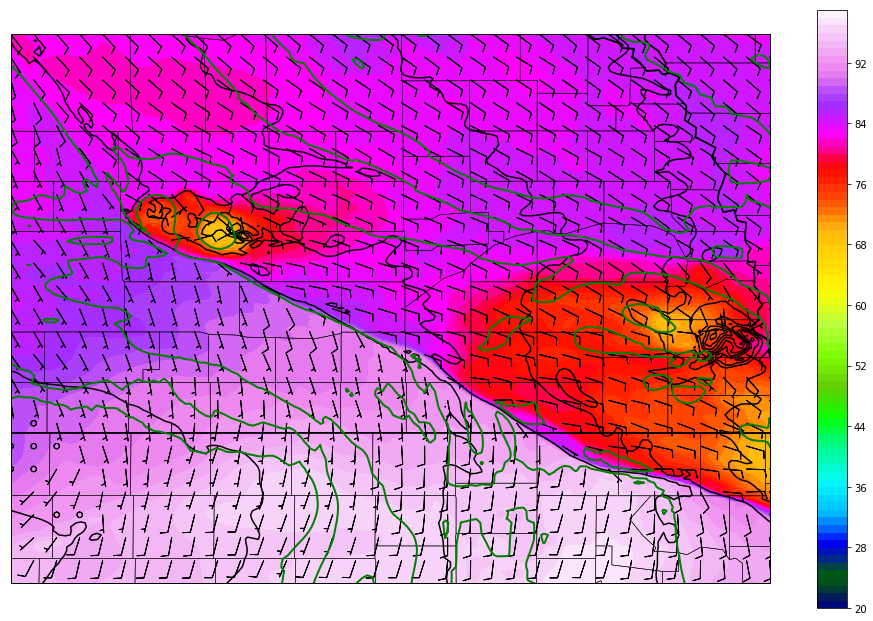

In [71]:
%matplotlib inline
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    #ax.add_geometries(Reader(fname).geometries(),
    #              ccrs.PlateCarree(),
    #              facecolor='white')
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    Tlev = np.arange(20, 100, 1)
    plev = np.arange(964,1060,2)
    Tdlev = np.arange(50,80,5)
    cs = ax.contourf(clons,clats,Tf[FH,:,:],Tlev,cmap=plt.cm.gist_ncar)
    cp = ax.contour(clons, clats,mslp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    cd = ax.contour(clons, clats,TDf[FH,:,:], Tdlev, linewidths = 2, colors = 'g')
    ax.barbs(clons,clats,U[FH,:,:],V[FH,:,:],length=6,regrid_shape=25)
    plt.colorbar(cs)
    #plt.savefig('ReadingDaysfc'+str(FH)+'.png')
    FH = FH+1
plt.show()

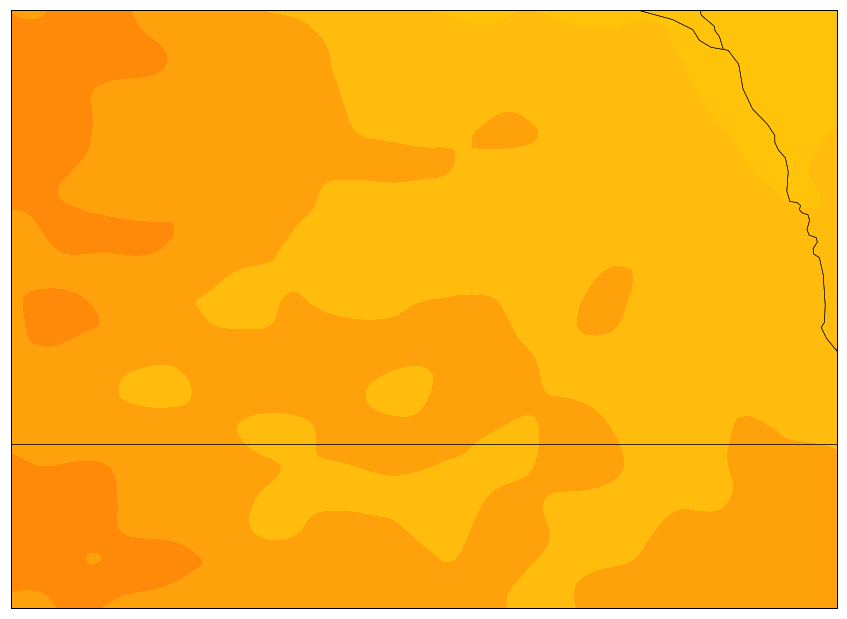

In [72]:
%matplotlib inline
fig=plt.figure(1,figsize=(17.,11.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
Tlev = np.arange(200, 350, 2)
cs = ax.contourf(clons,clats,pot2[0,:,:],Tlev,cmap=plt.cm.gist_ncar)
plt.show()

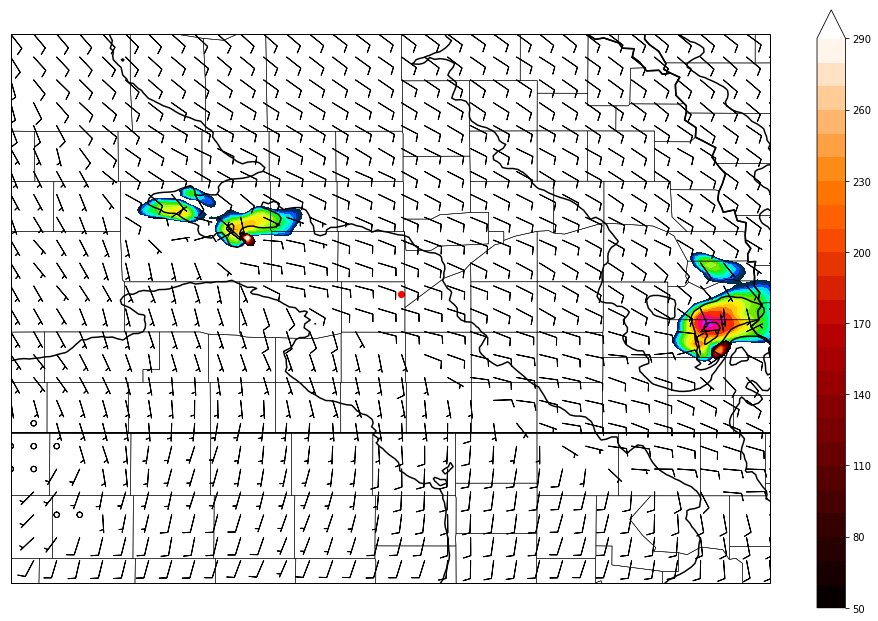

In [73]:
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Tlev = np.arange(50, 300, 10)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,u_helicity[FH,:,:]/100,Tlev,cmap=plt.cm.gist_heat, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    ax.barbs(clons,clats,U[FH,:,:],V[FH,:,:],length=6,regrid_shape=25)
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    #plt.savefig('wrfplot_ReadingDayref'+str(FH)+'.png')
    FH = FH+1
plt.show()

In [74]:
print(mcape.shape)
print(cape3.shape)

(4L, 19L, 150L, 150L)
(2L, 19L, 39L, 150L, 150L)


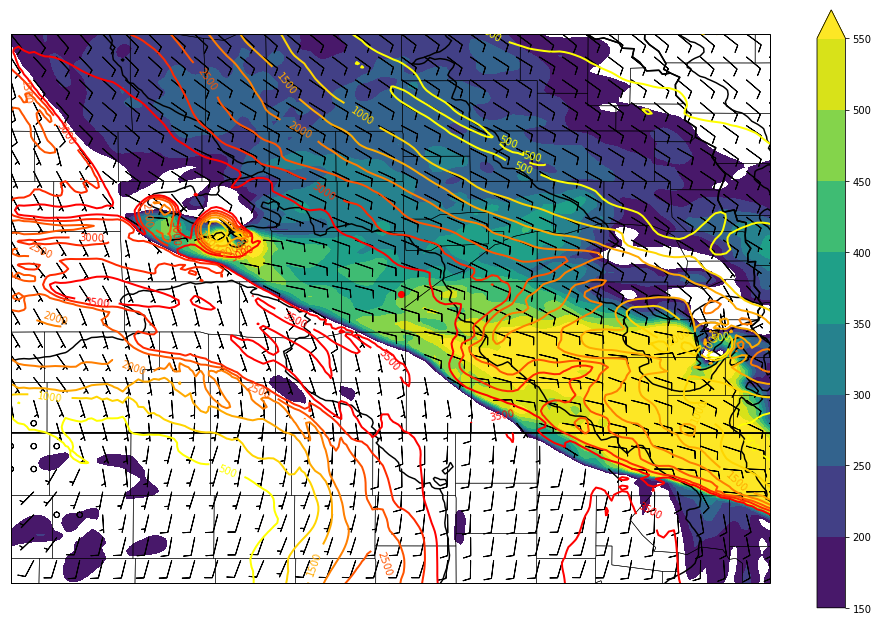

In [75]:
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    hlev = np.arange(150, 600, 50)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,70,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,helicity15[FH,:,:],hlev,cmap=plt.cm.viridis, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    ca = ax.contour(clons, clats,cape3[0,FH,0,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    ax.barbs(clons,clats,U[FH,:,:],V[FH,:,:],length=6,regrid_shape=25)
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    FH = FH+1
plt.show()

In [76]:
print(TD)

<xarray.DataArray u'td2' (Time: 19, south_north: 150, west_east: 150)>
array([[[ 10.875144,  10.853354, ...,  18.514576,  18.541565],
        [ 10.897498,  10.873291, ...,  18.420412,  18.440207],
        ..., 
        [  9.900939,   9.912706, ...,  12.44595 ,  12.423124],
        [  9.890492,   9.905971, ...,  12.452338,  12.428962]],

       [[ 11.379766,  11.459457, ...,  19.22678 ,  19.264969],
        [ 11.443488,  11.503991, ...,  19.126236,  19.163055],
        ..., 
        [ 10.757367,  10.755533, ...,  12.994864,  12.945001],
        [ 10.724141,  10.73206 , ...,  12.954891,  12.900488]],

       ..., 
       [[  0.663547,   0.827879, ...,  18.177225,  18.119953],
        [  0.597903,   0.747191, ...,  18.16935 ,  18.120735],
        ..., 
        [ 15.636209,  15.610443, ...,  16.20999 ,  15.400171],
        [ 15.483231,  15.420714, ...,  15.374224,  15.206864]],

       [[  0.867478,   1.153688, ...,  18.629122,  18.612923],
        [  0.858549,   1.102047, ...,  18.604021,

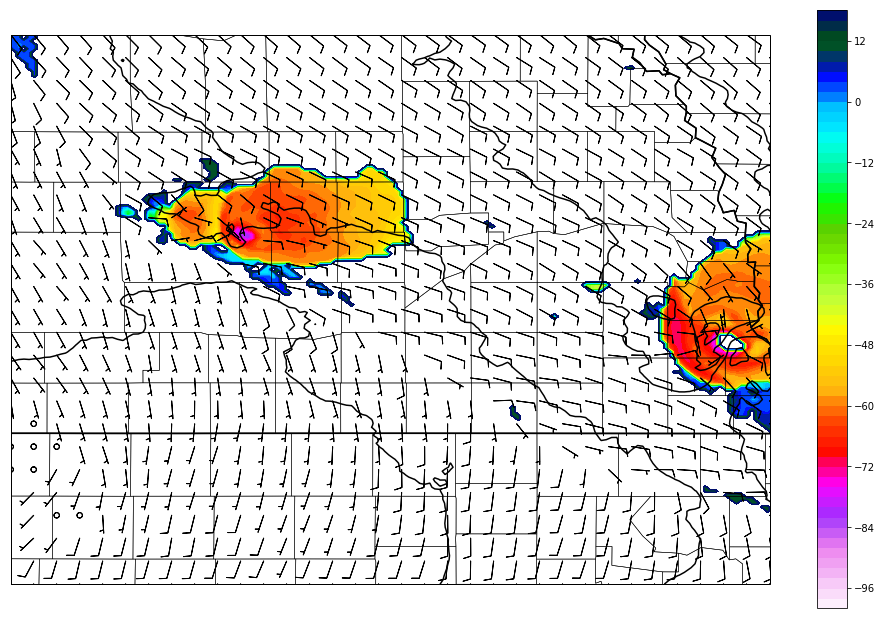

In [77]:
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Tlev = np.arange(50, 300, 10)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(-100,20,2)
    cf = ax.contourf(clons,clats,ir_sat[FH,:,:],dbzlev,cmap=plt.cm.gist_ncar_r)
    #cs = ax.contourf(clons,clats,u_helicity[FH,:,:]/100,Tlev,cmap=plt.cm.gist_heat, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    ax.barbs(clons,clats,U[FH,:,:],V[FH,:,:],length=6,regrid_shape=25)
    plt.colorbar(cf)
    #plt.savefig('ReadingDaysat'+str(FH)+'.png')
    FH = FH+1
plt.show()

In [78]:
def bulk_shear(u, v, p, hgt, top, bottom = None):
    r"""Calculate bulk shear through a layer. 
    
    Layer top and bottom specified in meters AGL:
    
    Parameters
    ----------
    u : array-like
        U-component of wind.
    v : array-like
        V-component of wind.
    p : array-like
        Atmospheric pressure profile
    hgt : array-like
        Heights from sounding
    top: `pint.Quantity`
        The top of the layer in meters AGL
    bottom: `pint.Quantity`
        The bottom of the layer in meters AGL.
        Default is the surface.
        
    Returns
    -------
    `pint.Quantity'
        u_shr: u-component of layer bulk shear, in m/s
    `pint.Quantity'
        v_shr: v-component of layer bulk shear, in m/s
    `pint.Quantity'
        shr_mag: magnitude of layer bulk shear, in m/s
        
    """   
    
    
    u = u.to('meters/second')
    v = v.to('meters/second')
    
    if bottom:
        depth_s = top - bottom
    else:
        depth_s = top
        
    w_int = get_layer(p, u, v, heights=hgt, bottom=bottom, depth=depth_s)
    
    u_shr = w_int[1][-1] - w_int[1][0]
    v_shr = w_int[2][-1] - w_int[2][0]
    
    shr_mag = np.sqrt((u_shr ** 2) + (v_shr ** 2))
    
    return u_shr, v_shr, shr_mag


In [79]:
def storm_relative_helicity(u, v, p, hgt, top, storm_u, storm_v, bottom = None):
    # Partially adapted from similar SharpPy code
    r"""Calculate Storm Relative Helicity.
    Needs u and v wind components, heights and pressures,
    and top and bottom of SRH layer. An optional storm
    motion vector can be specified.
    Parameters
    ----------
    u : array-like
        The u components of winds, same length as hgts
    v : array-like
        The u components of winds, same length as hgts
    p : array-like
        Pressure in hPa, same length as hgts
    hgts : array-like
        The heights associatd with the data, provided in meters above mean
        sea level and converted into meters AGL.
    top : number
        The height of the top of the desired layer for SRH.
    bottom : number
        The height at the bottom of the SRH layer. Default is sfc (None).
    storm_u : number
        u component of storm motion
    storm_v : number
        v component of storm motion

    Returns
    -------
    number
        p_srh : positive storm-relative helicity
    number
        n_srh : negative storm-relative helicity
    number
        t_srh : total storm-relative helicity
    """
    u = u.to('meters/second')
    v = v.to('meters/second')
    storm_u = storm_u.to('meters/second')
    storm_v = storm_v.to('meters/second')
    
    if bottom:
        depth_s = top - bottom
    else:
        depth_s = top

    w_int = get_layer(p, u, v, heights=hgt, bottom=bottom, depth=depth_s)
    
    sru = (w_int[1] - storm_u)
    srv = (w_int[2] - storm_v)

    int_layers = (sru[1:] * srv[:-1] - sru[:-1] * srv[1:])

    p_srh = int_layers[int_layers.magnitude > 0.].sum()
    n_srh = int_layers[int_layers.magnitude < 0.].sum()
    t_srh = p_srh + n_srh

    return p_srh, n_srh, t_srh

In [80]:
def mean_wind_pressure_weighted(u, v, hgt, p, top, bottom=None, interp=False):
    
    u = u.to('meters/second')
    v = v.to('meters/second')
    
    if bottom:
        depth_s = top - bottom
        bottom = bottom + hgt[0]
    else:
        depth_s = top
        
    if interp:
        dp = -1
        pressure_top = np.interp(top.magnitude, hgt.magnitude - hgt[0].magnitude, np.log(p.magnitude))
        pressure_top = np.exp(pressure_top)
        interp_levels = (np.arange(p[0].magnitude, pressure_top + dp, dp)) * units('hPa')
        u_int = log_interp(interp_levels, p, u)
        v_int = log_interp(interp_levels, p, v)
        h_int = log_interp(interp_levels, p, hgt)
        w_int = get_layer(interp_levels, u_int, v_int, heights=h_int, bottom=bottom, depth=depth_s)
    else:
        w_int = get_layer(p, u, v, heights=hgt, bottom=bottom, depth=depth_s)
    
    u_mean = ma.average(w_int[1], weights = w_int[0]) * units('m/s')
    v_mean = ma.average(w_int[2], weights = w_int[0]) * units('m/s')
    um = np.mean(w_int[1])
    vm = np.mean(w_int[2])
    print(u_mean.to('knot'), um.to('knot'))
    print(v_mean.to('knot'), vm.to('knot'))
    print(w_int[0][-1])
    print(w_int[0][0])

    
    return u_mean, v_mean
    

In [81]:
def bunkers_storm_motion(p, hgt, u, v, interp=False):

    r"""Calculate the Bunkers RM and LM storm motions, as 
    well as the mean sfc-6km flow for ordinary cell motion.
    Uses the storm motion calculation from [Bunkers et al, 2000],
    which does not require effective inflow layer calculations,
    unlike the more recent version in [Bunkers et al 2014].
    
    Parameters
    ----------
    u : (M) ndarray
        x component of the wind
    v : (M) ndarray
        y component of the wind
    
    Returns
    -------
    RM_vector
        u and v component of Bunkers RM storm motion
    LM_vector
        u and v component of Bunkers LM storm motion
    mean_vector
        u and v component of sfc-6km mean flow
        
    See Also
    --------
    bunkers_storm_motion_2014
    
    Citations:
    
    Bunkers, M. J., B. A. Klimowski, J. W. Zeitler, R. L. Thompson, and M. L. Weisman, 2000:
        Predicting supercell motion using a new hodograph technique. Wea. Forecasting, 15, 61–79.
    
    
    Bunkers, M. J., D. A. Barber, R. L. Thompson, R. Edwards, and J. Garner, 2014: 
        Choosing a universal mean wind for supercell motion prediction. J. Operational Meteor.,
        2 (11), 115–129, doi: https://dx.doi.org/10.15191/nwajom.2014.0211.
    
    
     """

    u = u.to('m/s')
    v = v.to('m/s')
    
    if interp:
        
        dp = -1
        pressure_top = np.interp(6000, hgt.magnitude - hgt[0].magnitude, np.log(p.magnitude))
        pressure_top = np.exp(pressure_top)
        interp_levels = (np.arange(p[0].magnitude, pressure_top + dp, dp)) * units('hPa')
        u = log_interp(interp_levels, p, u)
        v = log_interp(interp_levels, p, v)
        hgt = log_interp(interp_levels, p, hgt)
        p = interp_levels
    
    #mean wind from sfc-6km
    #correct height to be height AGL
    u6 = mean_wind_pressure_weighted(u, v, hgt, p, top = 6000 * units('meter'))
    u6m = u6[0]
    v6m = u6[1]

    #mean wind from sfc-500m

    u5 = mean_wind_pressure_weighted(u, v, hgt, p, top = 500 * units('meter'))
    u5m = u5[0]
    v5m = u5[1]

    #mean wind from 5.5-6km

    u55 = mean_wind_pressure_weighted(u, v, hgt, p, top = 6000 * units('meter'), bottom = 5500 * units('meter'))
    u55m = u55[0]
    v55m = u55[1]

    #Calculate the shear vector from sfc-500m to 5.5-6km

    u6shr = u55m - u5m
    v6shr = v55m - v5m

    #making the shear vector

    vl = [u6shr.magnitude, v6shr.magnitude, 0]

    #Create a k hat vector

    vk = [0,0,1]

    #Take the cross product of the wind shear and k, and divide by the vector magnitude and multiply by D (7.5 m/s or 14.5788 kt)
    rdev = np.cross(vl, vk)*(7.5/(np.sqrt(u6shr.magnitude ** 2 + v6shr.magnitude ** 2)))
    ldev = np.cross(vk, vl)*(7.5/(np.sqrt(u6shr.magnitude ** 2 + v6shr.magnitude ** 2)))
    
    #Add the deviations to the layer average wind to get the RM motion
    uRM = u6m.magnitude + rdev[0]
    vRM = v6m.magnitude + rdev[1]

    #Subtract the deviations to get the LM motion
    uLM = u6m.magnitude - rdev[0]
    vLM = v6m.magnitude - rdev[1]
    
    RM_vector = np.asarray([uRM, vRM])*units('m/s')
    
    LM_vector = np.asarray([uLM, vLM])*units('m/s')
    
    mean_vector = np.asarray([u6m.magnitude, v6m.magnitude])*units('m/s')
    #print('mean wind direction:'+str(get_wind_dir(u6m, v6m).magnitude))
    #print('rdev wind direction:'+str(get_wind_dir(rdev[0], rdev[1]).to('degree').magnitude))

    return RM_vector, LM_vector, mean_vector



In [82]:
#Supercell composite calculation. Should use mucape, esrh, and ebwd, but for now we'll use sbcape, sfc-3 srh, and sfc-6 shear
def supercell_comp(mucape, esrh, ebwd):
    
    ebwd = ebwd.to('m/s')
    ebwd = ebwd.magnitude
    inds = np.where((ebwd <= 20.) & (ebwd >= 10.))
    inds1 = np.where(ebwd < 10.)
    inds2 = np.where(ebwd > 20.)
    ebwd[inds] = ebwd[inds] / 20.
    ebwd[inds1] = 0.
    ebwd[inds2] = 1.
    sup_comp = (mucape.magnitude / 1000.) * (esrh.magnitude / 50.) * ebwd
     
    return sup_comp

In [83]:
#z = getvar(ncfile, "z", timeidx=ALL_TIMES)
zp = WRF_out.variables['PH'][:]
zb = WRF_out.variables['PHB'][:]
#Conversions
#Base and perturbation geopotential to geopotential height
z = ((zp + zb)/ 9.81) * units('meter')
z = z[:,:-1,:,:]
p = getvar(ncfile, "p", timeidx=ALL_TIMES)/100.

print(p)

<xarray.DataArray u'pressure' (Time: 19, bottom_top: 39, south_north: 150, west_east: 150)>
array([[[[ 904.761414, ...,  974.202393],
         ..., 
         [ 900.868958, ...,  960.138489]],

        ..., 
        [[ 103.965553, ...,  104.318054],
         ..., 
         [ 103.944794, ...,  104.233444]]],


       ..., 
       [[[ 900.942322, ...,  969.42804 ],
         ..., 
         [ 901.605408, ...,  961.552368]],

        ..., 
        [[ 103.98362 , ...,  104.318253],
         ..., 
         [ 103.946434, ...,  104.243195]]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.098 -101.062 -101.026 ...
    XLAT     (south_north, west_east) float32 38.8209 38.8209 38.8209 ...
    XTIME    (Time) float32 0.0 60.0 120.0 180.0 240.0 300.0 360.0 420.0 ...
  * Time     (Time) datetime64[ns] 1980-06-03T12:00:00 1980-06-03T13:00:00 ...
Dimensions without coordinates: bottom_top, south_north, west_east


In [84]:
#RM, LM, mean = Bunkers_storm_motion(p, z, Uc, Vc)
from metpy.calc.tools import get_layer as get_layer1
from metpy.units import units

In [85]:
p = np.array(p) * units('hPa')
Uc = np.array(Uc) * units('m/s')
Vc = np.array(Vc) * units('m/s')
Uk = Uc.to('knot')
Vk = Vc.to('knot')
z = np.array(z) * units('meter')
top = 1000 * units('meter')
print(top.dimensionality)
print(p.shape[2])
RMu = np.zeros((p.shape[2], p.shape[3]))
RMv = np.zeros((p.shape[2], p.shape[3]))
LMu = np.zeros((p.shape[2], p.shape[3]))
LMv = np.zeros((p.shape[2], p.shape[3]))
meanu = np.zeros((p.shape[2], p.shape[3]))
meanv = np.zeros((p.shape[2], p.shape[3]))


[length]
150


In [86]:
print(p.shape, z.shape, Uk.shape)
from metpy.calc import get_layer

((19L, 39L, 150L, 150L), (19L, 39L, 150L, 150L), (19L, 39L, 150L, 151L))


In [87]:
Uc = np.float64(Uc) * units('m/s')
Vc = np.float64(Vc) * units('m/s')
p = np.float64(p) * units('hPa')
z = np.float64(z) * units('meters')
Ucr = np.round(Uc)
Vcr = np.round(Vc)
pr = np.round(p)
zr = np.round(z)
print(np.max(Ucr))
Ucr[0,:,0,0]
zr[0,:,0,0]

83.0 meter / second


<Quantity([   913.    967.   1044.   1146.   1273.   1436.   1644.   1890.   2135.
   2385.   2641.   2902.   3404.   3904.   4401.   4895.   5387.   5878.
   6367.   6855.   7340.   7824.   8306.   8786.   9263.   9739.  10214.
  10688.  11163.  11639.  12118.  12602.  13091.  13585.  14082.  14573.
  15058.  15539.  16015.], 'meter')>

In [88]:
hgt_layer = get_layer(np.asarray(p[0,:,0,0]) * units('hPa'), np.asarray(z[0,:,0,0]) * units('meter'), heights = np.asarray(z[0,:,0,0]) * units('meter'), depth = (1000 * units('meter')))
print(hgt_layer)

[<Quantity([ 904.76141357  897.95812988  888.4263916   876.72021484  862.09741211
  843.86810303  821.98931885  798.88336182  796.71658515], 'hectopascal')>, <Quantity([  913.39648438   966.64892578  1043.9720459   1145.82775879  1273.3248291
  1435.8704834   1643.57128906  1890.07177734  1913.09431774], 'meter')>]


In [89]:
#%%timeit
for i in range(p.shape[2]):
    for j in range(p.shape[3]):
        RM1, LM1, mean1 = Bunkers_storm_motion(p[11,:,i,j], z[11,:,i,j], Uk[11,:,i,j], Vk[11,:,i,j])
        RMu[i,j] = RM1[0].magnitude
        RMv[i,j] = RM1[1].magnitude
        LMu[i,j] = LM1[0].magnitude
        LMv[i,j] = LM1[1].magnitude
        meanu[i,j] = mean1[0].magnitude
        meanv[i,j] = mean1[1].magnitude

In [90]:

RM1t, LM1t, mean1t = Bunkers_storm_motion(p[11,:,78,77], z[11,:,78,77], Uc[11,:,78,77], Vc[11,:,78,77])
print(RM1t)
print(RMu[78,77], RMv[78,77])
print(RMu)

[ 1.28704591 -4.16265073] knot
(0.81653670684693236, 5.5649807643097553)
[[ 26.89549429  27.06947316  27.28286693 ...,  11.0634241   10.95773327
   10.66368317]
 [ 26.84337864  26.91558908  27.30431038 ...,  11.17586113  10.96801385
   10.53958261]
 [ 27.17974188  27.03992979  27.27011277 ...,  11.01209544  10.83136258
   10.3944616 ]
 ..., 
 [ -1.89686011  -2.26594637  -2.61216672 ...,   0.49086206   0.76235652
    0.98269101]
 [ -2.04439074  -2.43065846  -2.73708875 ...,   0.7826753    1.02486807
    1.19507273]
 [ -2.21399213  -2.56348436  -2.88975052 ...,   1.04699079   1.19310525
    1.33070168]]


In [91]:
Uc = np.asarray(Uc) * units('m/s')
Vc = np.asarray(Vc) * units('m/s')
p = np.asarray(p) * units('hPa')
z = np.asarray(z) * units('meters')
Uc[0,:,0,0]
#print(Uc[0,:,0,0])

<Quantity([ -2.05903411  -1.43104362  -0.57373542   0.52394122   2.45471144
   4.33910418   5.19667339   5.65506458   6.0003233    6.63004351
   7.42241001   8.9453392   11.61949062  13.02774143  12.61341953
  11.76124001  12.58762264  13.79726982  15.1385603   16.86857414
  18.82050514  20.86338043  22.89512253  24.84923172  27.052248
  29.94823837  33.16270447  36.57893372  39.5879097   40.94457626
  40.43717575  38.33063507  35.39046478  32.32822037  29.67585182
  27.38307381  25.21444893  23.02549362  20.89330673], 'meter / second')>

In [92]:
psrh3 = np.zeros((p.shape[2], p.shape[3]))
nsrh3 = np.zeros((p.shape[2], p.shape[3]))
tsrh3 = np.zeros((p.shape[2], p.shape[3]))
for i in range(p.shape[2]):
    for j in range(p.shape[3]):
        srh3 = storm_relative_helicity(Uc[11,:,i,j], Vc[11,:,i,j], p[11,:,i,j], z[11,:,i,j], 
                                       top = 3000 * units('meter'), storm_u = RMu[i,j] * units.knots, 
                                       storm_v = RMv[i,j] * units.knots)
        psrh3[i,j] = srh3[0].magnitude
        nsrh3[i,j] = srh3[1].magnitude
        tsrh3[i,j] = srh3[2].magnitude

In [93]:
ushr6 = np.zeros((p.shape[2], p.shape[3]))
vshr6 = np.zeros((p.shape[2], p.shape[3]))
mshr6 = np.zeros((p.shape[2], p.shape[3]))
for i in range(p.shape[2]):
    for j in range(p.shape[3]):
        shr6 = bulk_shear(Uc[11,:,i,j], Vc[11,:,i,j], p[11,:,i,j], z[11,:,i,j], 
                          top = 6000 * units('meter'))
        ushr6[i,j] = shr6[0].magnitude
        vshr6[i,j] = shr6[1].magnitude
        mshr6[i,j] = shr6[2].magnitude

In [94]:
mshr6 = mshr6 * units('m/s')
moocape = np.asarray(mcape[0,FH,:,:]) * units('J/kg')
psrh3 = psrh3 * units('m^2/s^2')
print(moocape)
sup_comp_def = supercell_comp(moocape, psrh3, mshr6.to('knots'))
print(mshr6.units, moocape.units, psrh3.units)

[[           nan            nan            nan ...,  3730.22338867   3679.61230469  3602.40844727] [           nan            nan            nan ...,  3732.89086914   3692.81103516  3612.58544922] [           nan            nan            nan ...,  3736.77783203   3703.98413086  3620.62597656] ...,  [ 3401.10327148  3597.35253906  3581.32958984 ...,  1055.38549805   1007.75689697   912.19348145] [ 3482.07250977  3613.74951172  3551.17871094 ...,  1043.28674316    987.35931396   879.95269775] [ 3529.48974609  3597.16015625  3529.52661133 ...,   975.76080322    907.55279541   830.66412354]] joule / kilogram
(<Unit('meter / second')>, <Unit('joule / kilogram')>, <Unit('meter ** 2 / second ** 2')>)


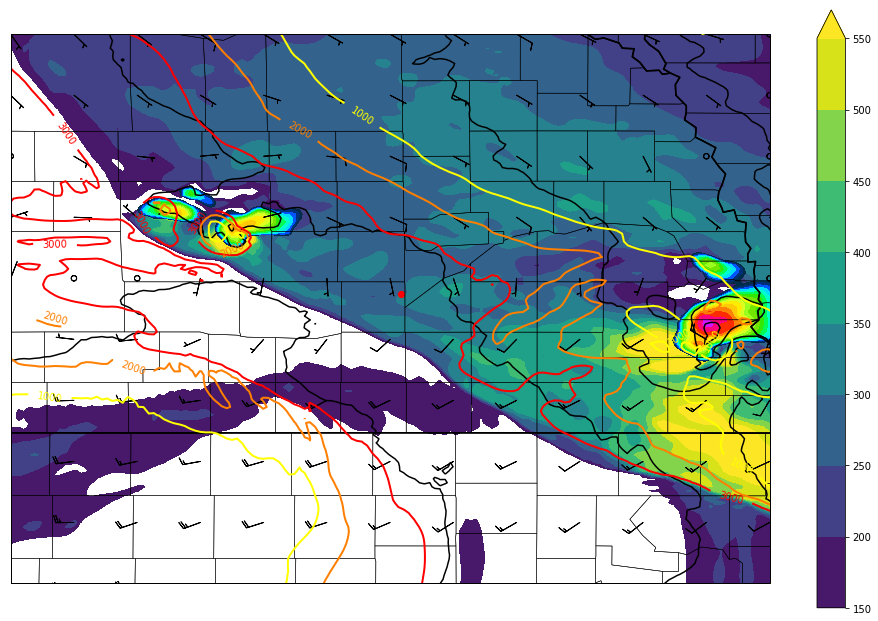

In [95]:
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    hlev = np.arange(150, 600, 50)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(1000,4000,1000)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,psrh3[:,:],hlev,cmap=plt.cm.viridis, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    ca = ax.contour(clons, clats,cape3[0,FH,0,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=10)
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    FH = FH+1
plt.show()

In [96]:
print(mcape.shape)
print(np.max(mcape[0,11,:,:]))

(4L, 19L, 150L, 150L)
<xarray.DataArray u'cape_2d' ()>
array(4451.8466796875)
Coordinates:
    XTIME               float32 660.0
    Time                datetime64[ns] 1980-06-03T23:00:00
    mcape_mcin_lcl_lfc  <U5 u'mcape'


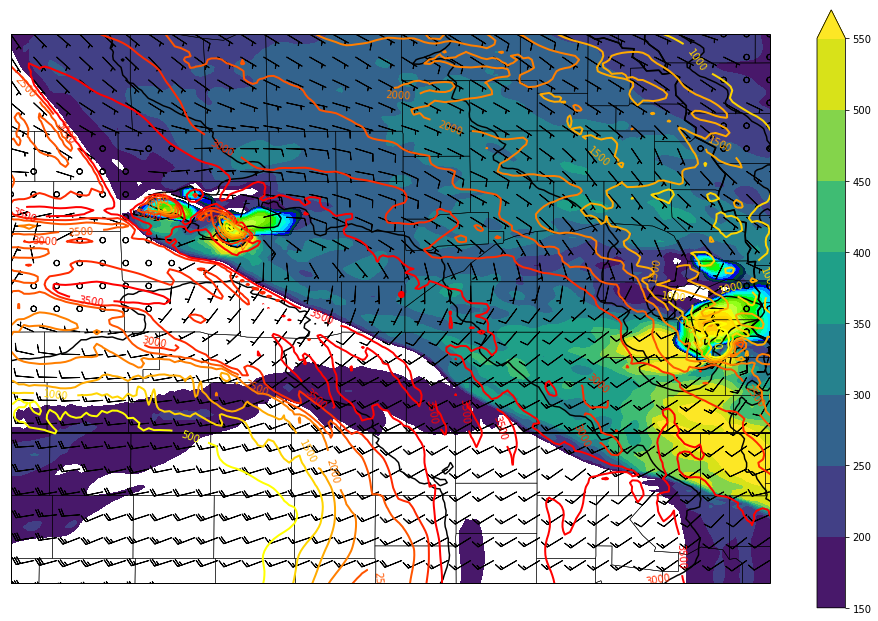

In [97]:
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    hlev = np.arange(150, 600, 50)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,70,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,psrh3[:,:],hlev,cmap=plt.cm.viridis, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=25)
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    FH = FH+1
plt.show()

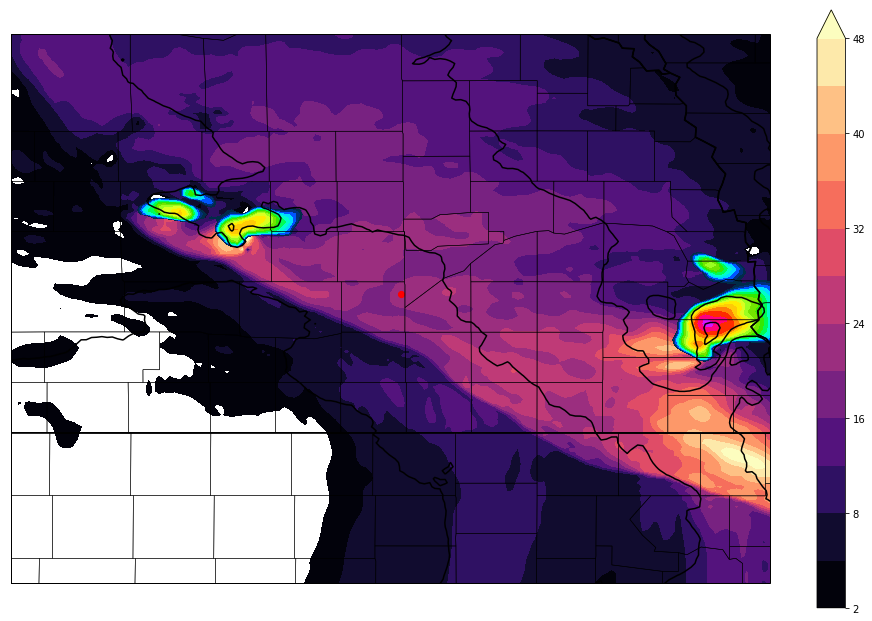

In [98]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    SCclev = [2, 4, 8,12,16,20,24,28,32,36,40,44,48]
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,sup_comp_def,SCclev,cmap=plt.cm.magma, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    #ax.barbs(clons,clats,uc,vc,length=6,regrid_shape=25)
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    FH = FH+1
plt.show()

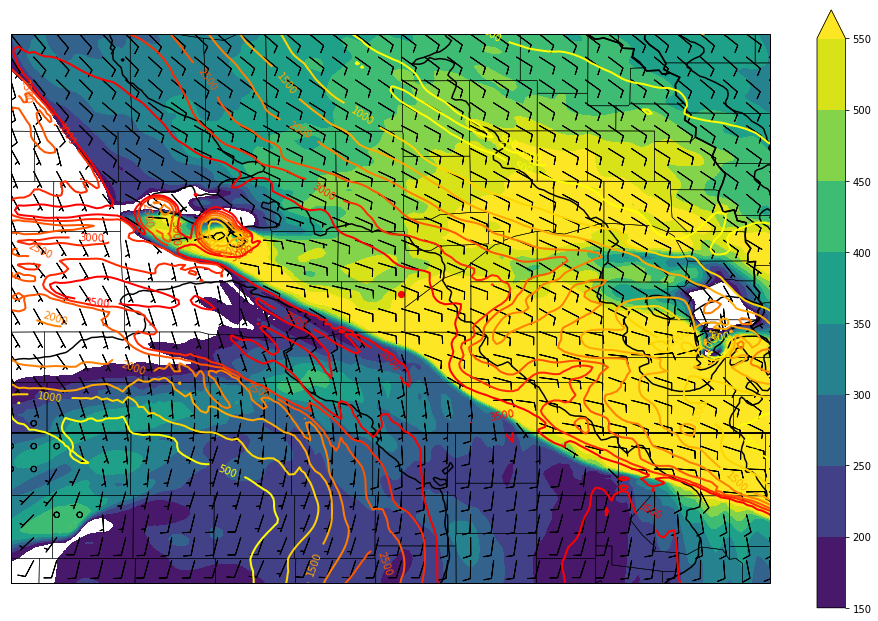

In [99]:
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    hlev = np.arange(150, 600, 50)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,70,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,helicity3[FH,:,:],hlev,cmap=plt.cm.viridis, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    ca = ax.contour(clons, clats,cape3[0,FH,0,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    ax.barbs(clons,clats,U[FH,:,:],V[FH,:,:],length=6,regrid_shape=25)
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    FH = FH+1
plt.show()

In [100]:
print(psrh3[78,77])

287.523532555 meter ** 2 / second ** 2


In [101]:
#Let's plot a visualization for critical angle
#First, we need sfc-500 shear
ushr5 = np.zeros((p.shape[2], p.shape[3]))
vshr5 = np.zeros((p.shape[2], p.shape[3]))
mshr5 = np.zeros((p.shape[2], p.shape[3]))
for i in range(p.shape[2]):
    for j in range(p.shape[3]):
        shr5= bulk_shear(Uc[11,:,i,j], Vc[11,:,i,j], p[11,:,i,j], z[11,:,i,j], 
                          top = 500 * units('meter'))
        ushr5[i,j] = shr5[0].magnitude
        vshr5[i,j] = shr5[1].magnitude
        mshr5[i,j] = shr5[2].magnitude

In [102]:
ushr5 = ushr5 * units('m/s')
ushr5 = ushr5.to('knot')
vshr5 = vshr5 * units('m/s')
vshr5 = vshr5.to('knot')

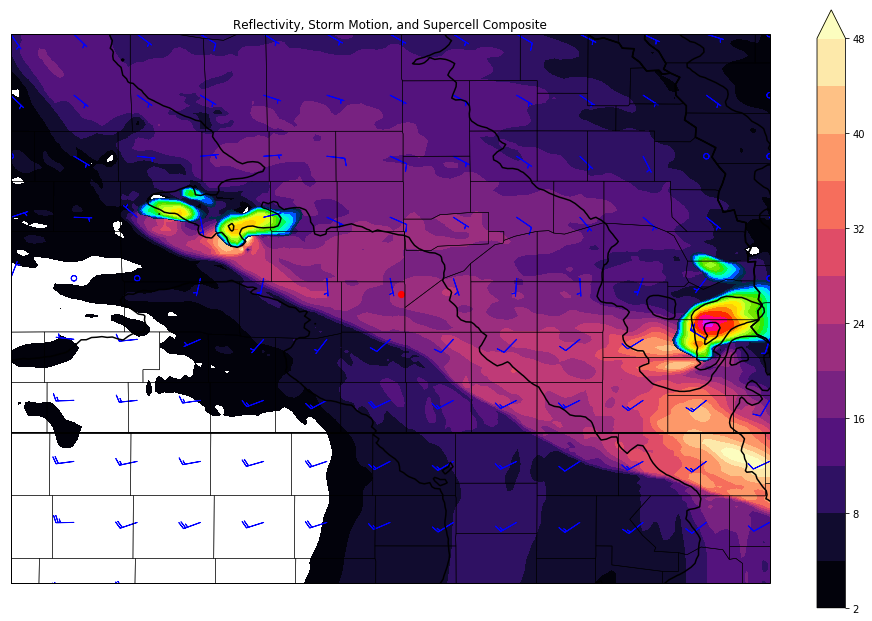

In [103]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    SCclev = [2, 4, 8,12,16,20,24,28,32,36,40,44,48]
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,sup_comp_def,SCclev,cmap=plt.cm.magma, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    #ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'r')
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=10, color = 'b')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    plt.savefig('wrfplot_OldSupercellComp.png')
    plt.title("Reflectivity, Storm Motion, and Supercell Composite")
    FH = FH+1
plt.show()

In [104]:
def critical_angle_1(ushr, vshr, um, vm, usfc, vsfc):
    """Will calculate the critical angle between the storm motion vector (RM) and
       the sfc-500m shear vector"""  
    
    #Make everything relative to the sfc wind orientation
    umn = um - usfc
    vmn = vm - vsfc
    
    #Get direction of each vector
    shrdir = get_wind_dir(ushr, vshr)
    smdir = get_wind_dir(umn,vmn)
    #Account for really weird, unlikely storm motions to the SW
    inds1 = np.where((smdir.magnitude < shrdir.magnitude) & (smdir.magnitude < 90.))
    smdir[inds1] = smdir[inds1] + (360. * units('degrees')) 
    critical_angle = smdir - shrdir
    
    return critical_angle

In [105]:
def critical_angle(ushr, vshr, um, vm, usfc, vsfc):
    """Will calculate the critical angle between the storm motion vector (RM) and
       the sfc-500m shear vector"""  
    
    #Make everything relative to the sfc wind orientation
    umn = um - usfc
    vmn = vm - vsfc
    
    #Get direction of each vector
    shrdir = get_wind_dir(ushr, vshr)
    smdir = get_wind_dir(umn,vmn)
    #Account for really weird, unlikely storm motions to the SW
    #inds1 = np.where((smdir.magnitude < shrdir.magnitude) & (smdir.magnitude < 90.))
    #print(inds1)
    #print(smdir.shape)
    smdir[(smdir.magnitude < shrdir.magnitude) & (smdir.magnitude < 90.)] = smdir[(smdir.magnitude < shrdir.magnitude) & (smdir.magnitude < 90.)] + (360. * units('degrees')) 
    critical_angle = smdir - shrdir
    
    return critical_angle

In [106]:
critical_ang = critical_angle(ushr5, vshr5, RMu * units('knot'), RMv * units('knot'), U[FH,:,:] * units('knot'), V[FH,:,:] * units('knot'))

In [107]:
print(critical_ang)

[[  51.99553305   53.13769053   53.83110798 ...,  127.60851136   119.38977247   71.23530123] [  51.64454263   53.01361219   54.40362486 ...,  125.22275542   116.70384683   73.00603663] [  50.87876644   52.46575848   53.6897291  ...,  120.13718102   113.36495356   71.0638964 ] ...,  [ 122.35425375  127.08657038  135.10007571 ...,  162.05366732   161.68427401  162.46387777] [ 123.33097816  130.48043911  139.99016518 ...,  162.36395097  162.0644121   162.57144822] [ 127.35891445  133.80533335  142.34385178 ...,  163.34687096   163.30964988  163.29018685]] degree


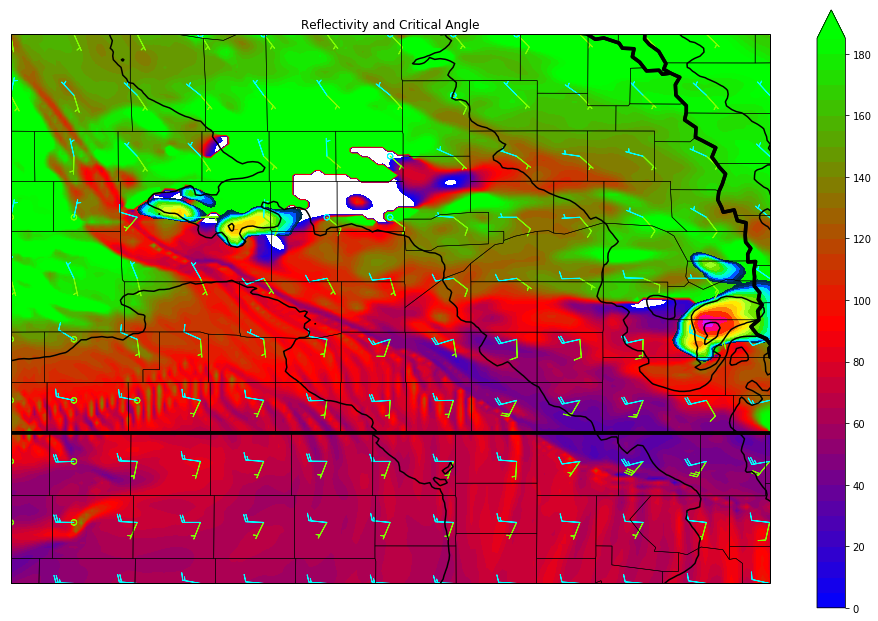

In [108]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 3.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Clev = np.arange(0, 190, 5)
    CAlev = [70, 120]
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,critical_ang,Clev,cmap=plt.cm.brg, extend = "max")
    #cz = ax.contour(clons, clats,critical_ang, CAlev, linewidths = 2, cmap = plt.cm.autumn_r)
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'chartreuse')
    ax.barbs(clons,clats,RMu-U[FH,:,:],RMv-V[FH,:,:],length=6,regrid_shape=10, color = 'cyan')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    plt.title("Reflectivity and Critical Angle")
    plt.savefig('wrfplot_CriticalAngle.png')
    FH = FH+1
plt.show()

In [109]:
srhtest = helicity3[FH,:,:] / psrh3
print(psrh3.units)
srhdiff = helicity3[FH,:,:] - (psrh3 / (1 * units('m^2/s^2'))) 

meter ** 2 / second ** 2


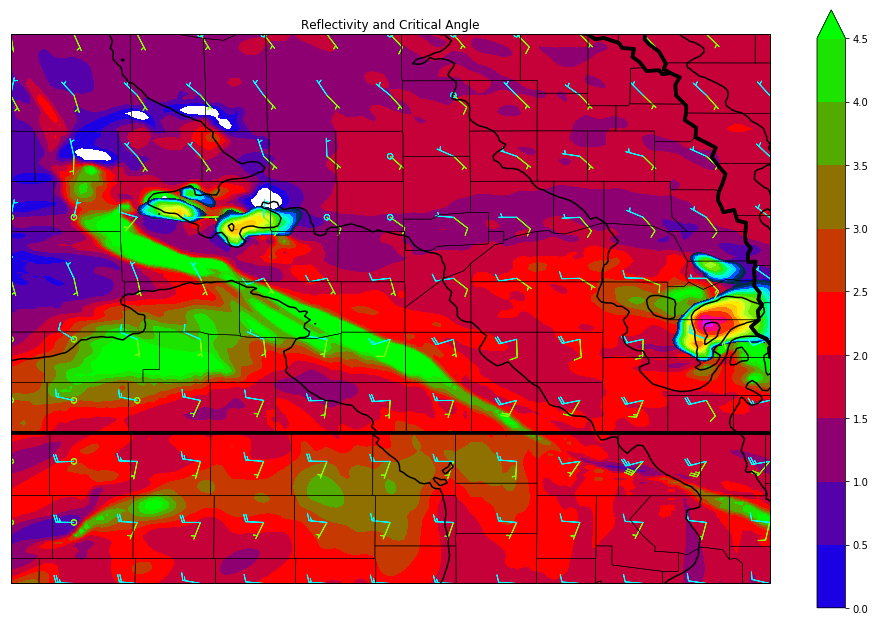

In [110]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 3.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Clev = np.arange(0, 5, .5)
    CAlev = [70, 120]
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,srhtest,Clev,cmap=plt.cm.brg, extend = "max")
    #cz = ax.contour(clons, clats,critical_ang, CAlev, linewidths = 2, cmap = plt.cm.autumn_r)
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'chartreuse')
    ax.barbs(clons,clats,RMu-U[FH,:,:],RMv-V[FH,:,:],length=6,regrid_shape=10, color = 'cyan')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    plt.title("Reflectivity and Critical Angle")
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    FH = FH+1
plt.show()

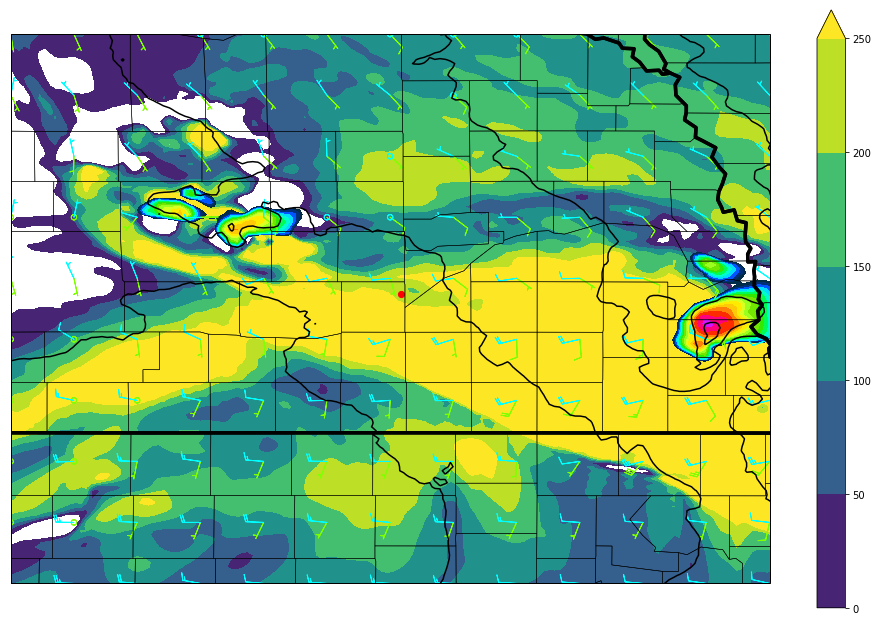

In [111]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 3.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Clev = np.arange(0, 300, 50)
    CAlev = [70, 120]
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,srhdiff,Clev,cmap=plt.cm.viridis, extend = "max")
    #cz = ax.contour(clons, clats,critical_ang, CAlev, linewidths = 2, cmap = plt.cm.autumn_r)
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'chartreuse')
    ax.barbs(clons,clats,RMu-U[FH,:,:],RMv-V[FH,:,:],length=6,regrid_shape=10, color = 'cyan')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    #plt.title("Reflectivity and Critical Angle")
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    FH = FH+1
plt.show()

In [112]:
psrh1 = np.zeros((p.shape[2], p.shape[3]))
nsrh1 = np.zeros((p.shape[2], p.shape[3]))
tsrh1 = np.zeros((p.shape[2], p.shape[3]))
for i in range(p.shape[2]):
    for j in range(p.shape[3]):
        srh1 = storm_relative_helicity(Uc[11,:,i,j], Vc[11,:,i,j], p[11,:,i,j], z[11,:,i,j], 
                                       top = 1000 * units('meter'), storm_u = RMu[i,j] * units.knots, 
                                       storm_v = RMv[i,j] * units.knots)
        psrh1[i,j] = srh1[0].magnitude
        nsrh1[i,j] = srh1[1].magnitude
        tsrh1[i,j] = srh1[2].magnitude

In [113]:
def sigtor(sbcape, sblcl, srh1, shr6):
    
    shr6 = shr6.to('m/s')
    shr6 = shr6.magnitude
    sblcl = sblcl.magnitude
    ind = np.where((sblcl <= 2000.) & (sblcl >= 1000.))
    ind1 = np.where(sblcl < 1000.)
    ind2 = np.where(sblcl > 2000.)
    sind = np.where((shr6 <= 30.) & (shr6 >= 12.5))
    sind1 = np.where(shr6 < 12.5)
    sind2 = np.where(shr6 > 30.)
    sblcl[ind] = (2000. - sblcl[ind]) / 1000.
    sblcl[ind1] = 1.
    sblcl[ind2] = 0.
    shr6[sind] = shr6[sind] / 20.
    shr6[sind1] = 0.
    shr6[sind2] = 1.5
    sigtor = (sbcape.magnitude / 1500.) * sblcl * (srh1.magnitude / 150.) * shr6
     
    return sigtor

In [114]:
lcl = np.asarray(mcape[2,FH,:,:]) * units('meter') - z[11,0,:,:]
sbcape = np.asarray(cape3[0,FH,0,:,:]) * units('J/kg')
psrh = psrh1 * units('m^2/s^2')
shr6 = mshr6
print(lcl[78, 77])

1067.63916016 meter


In [115]:
sigtor_p = sigtor(sbcape, lcl, psrh, shr6.to('knots'))

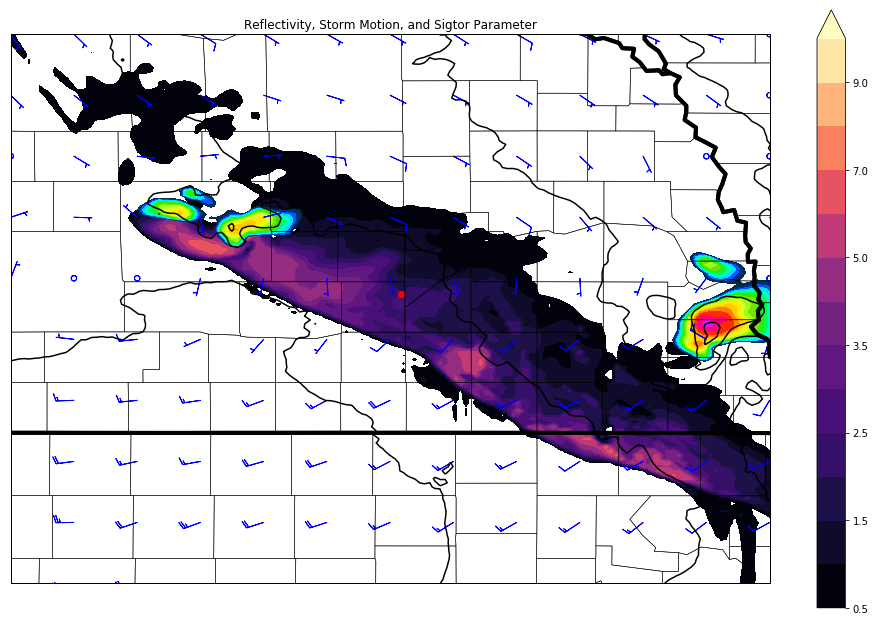

In [116]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 4)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Splev = [.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7, 8, 9, 10]
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,sigtor_p,Splev,cmap=plt.cm.magma, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    #ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'r')
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=10, color = 'b')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    plt.savefig('wrfplot_sigtor.png')
    plt.title("Reflectivity, Storm Motion, and Sigtor Parameter")
    FH = FH+1
plt.show()

In [117]:
print(cape3[0,11,35,:,:])

<xarray.DataArray u'cape_3d' (south_north: 150, west_east: 150)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
    XLONG     (south_north, west_east) float32 -101.098 -101.062 -101.026 ...
    XLAT      (south_north, west_east) float32 38.8209 38.8209 38.8209 ...
    XTIME     float32 660.0
    Time      datetime64[ns] 1980-06-03T23:00:00
    cape_cin  <U4 u'cape'
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:      104
    MemoryOrder:    XYZ
    description:    cape; cin
    units:          J kg-1 ; J kg-1
    stagger:        
    coordinates:    XLONG XLAT XTIME
    projection:     Mercator(stand_lon=-90.0, moad_cen_lat=40.9599761963, tru...
    _FillValue:  

In [118]:
print(cape3.shape)

(2L, 19L, 39L, 150L, 150L)


In [119]:
capee3 = cape3[0,:,:,:,:]
capee3[np.where(cape3 == np.nan)[0]] = 0
cin3 = cape3[1,:,:,:,:]
cin3[np.where(cin3 == np.nan)[0]] == 500
not_effective = np.where((capee3 < 100.) | (cin3 > 250.) | np.isnan(capee3) | np.isnan(cin3))
#effective = np.where((cape3[0,:,:,:,:] > 100.) & (cape3[1,:,:,:,:] < 250.))

#effective_b = cape3[((cape3[0,:,:,:,:] > 100.) & (cape3[1,:,:,:,:] < 250.))]
#print(effective[1].shape)

In [120]:
z1 = z[:,:,:,:] * 1.00
zdup = np.asarray(z[:,:,:,:])
zdup[not_effective] = np.NaN
#print[z]
eff_inflow_base = np.nanmin(zdup, axis = 1) 
eff_inflow_top = np.nanmax(zdup, axis = 1)
print(eff_inflow_top)
#print(eff_inflow_top)
print(zdup[11,36,:,:])
print(capee3[11,36,:,:])

[[[           nan            nan            nan ...,  1087.43273926
    1083.26184082  1080.14013672]
  [           nan            nan            nan ...,  1085.74975586
    1081.19702148  1077.67272949]
  [           nan            nan            nan ...,  1083.25305176
    1078.41149902  1074.55444336]
  ..., 
  [           nan            nan            nan ...,   950.94036865
     950.20898438   947.97497559]
  [           nan            nan            nan ...,   952.30029297
     952.01239014   950.17767334]
  [           nan            nan            nan ...,   953.58734131
     953.57440186   952.22064209]]

 [[           nan            nan            nan ...,  1088.05432129
    1083.90783691  1080.82055664]
  [           nan            nan            nan ...,  1086.38098145
    1081.86621094  1078.38525391]
  [           nan            nan            nan ...,  1083.92358398
    1079.11706543  1075.30065918]
  ..., 
  [           nan            nan            nan ...,   789.00555

C:\Users\matts\Miniconda3\envs\wrf_py_env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: All-NaN axis encountered
  """
C:\Users\matts\Miniconda3\envs\wrf_py_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  


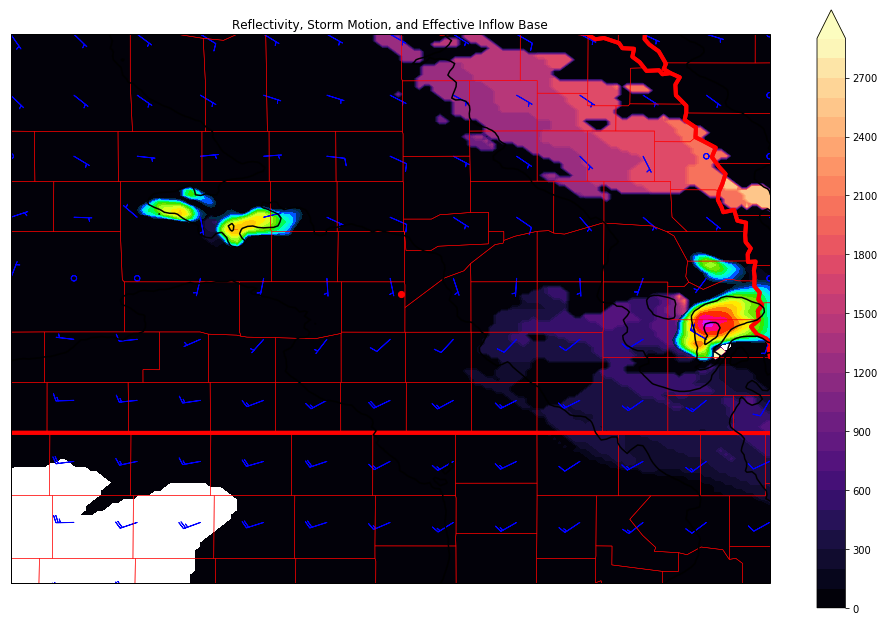

In [121]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'red', linewidth = 4)
    ax.add_feature(counties, edgecolor = 'red', linewidth = 0.5)
    Splev = np.arange(0,3000,100)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,eff_inflow_base[FH,:,:] * units('meter')-z1[11,0,:,:],Splev,cmap=plt.cm.magma, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    #ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'r')
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=10, color = 'b')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    plt.savefig('wrfplot_InflowBase.png')
    plt.title("Reflectivity, Storm Motion, and Effective Inflow Base")
    FH = FH+1
plt.show()

In [122]:
print(z.shape)

(19L, 39L, 150L, 150L)


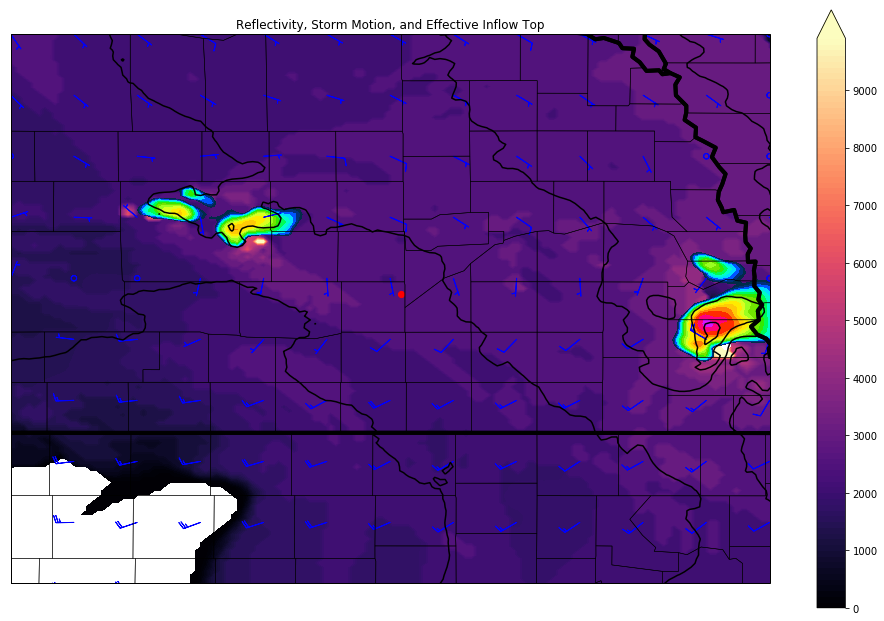

In [123]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 4)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Splev = np.arange(0,10000,100)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,eff_inflow_top[FH,:,:] * units('meter') - z1[11,0,:,:],Splev,cmap=plt.cm.magma, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    #ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'r')
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=10, color = 'b')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    plt.savefig('wrfplot_InflowTop.png')
    plt.title("Reflectivity, Storm Motion, and Effective Inflow Top")
    FH = FH+1
plt.show()

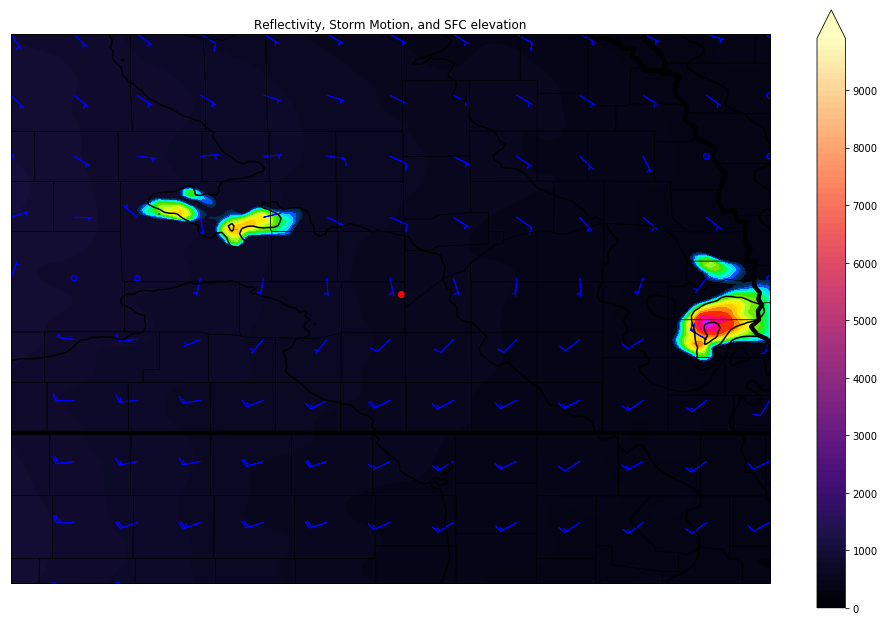

In [124]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 4)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Splev = np.arange(0,10000,100)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,z1[11,0,:,:],Splev,cmap=plt.cm.magma, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    #ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'r')
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=10, color = 'b')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    plt.title("Reflectivity, Storm Motion, and SFC elevation")
    FH = FH+1
plt.show()

In [125]:
effective_layer_depth = eff_inflow_top - eff_inflow_base

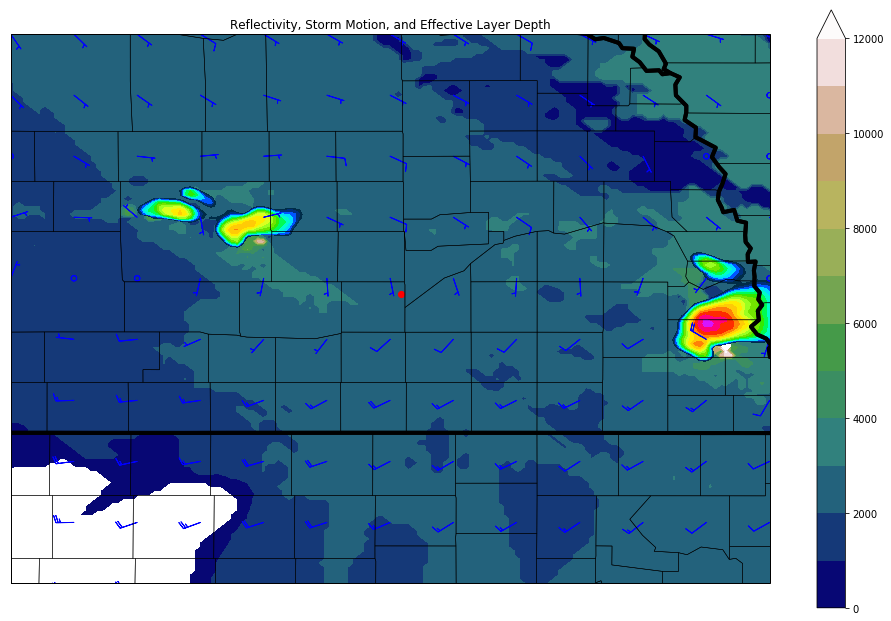

In [126]:
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 4)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    Splev = np.arange(0,13000,1000)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,effective_layer_depth[FH,:,:],Splev,cmap=plt.cm.gist_earth, extend = "max")
    #cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    #ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'r')
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=10, color = 'b')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    plt.savefig('wrfplot_EffectiveLayerDepth.png')
    plt.title("Reflectivity, Storm Motion, and Effective Layer Depth")
    FH = FH+1
plt.show()

In [127]:
print(z1.units)

meter


In [128]:
psrhe = np.zeros((p.shape[2], p.shape[3]))
nsrhe = np.zeros((p.shape[2], p.shape[3]))
tsrhe = np.zeros((p.shape[2], p.shape[3]))
for i in range(p.shape[2]):
    for j in range(p.shape[3]):
        if np.isnan(eff_inflow_base[11,i,j]):
            psrhe[i,j] = np.nan
            nsrhe[i,j] = np.nan
            tsrhe[i,j] = np.nan
        elif eff_inflow_top[11,i,j] == eff_inflow_base[11,i,j]:
            psrhe[i,j] = np.nan
            nsrhe[i,j] = np.nan
            tsrhe[i,j] = np.nan
        else:
            srhe = storm_relative_helicity(Uc[11,:,i,j], Vc[11,:,i,j], p[11,:,i,j], z1[11,:,i,j], 
                                           top = eff_inflow_top[11,i,j] * units('meter'), 
                                           bottom = eff_inflow_base[11,i,j] * units('meter'), storm_u = RMu[i,j] * units.knots, 
                                           storm_v = RMv[i,j] * units.knots)
            psrhe[i,j] = srhe[0].magnitude
            nsrhe[i,j] = srhe[1].magnitude
            tsrhe[i,j] = srhe[2].magnitude

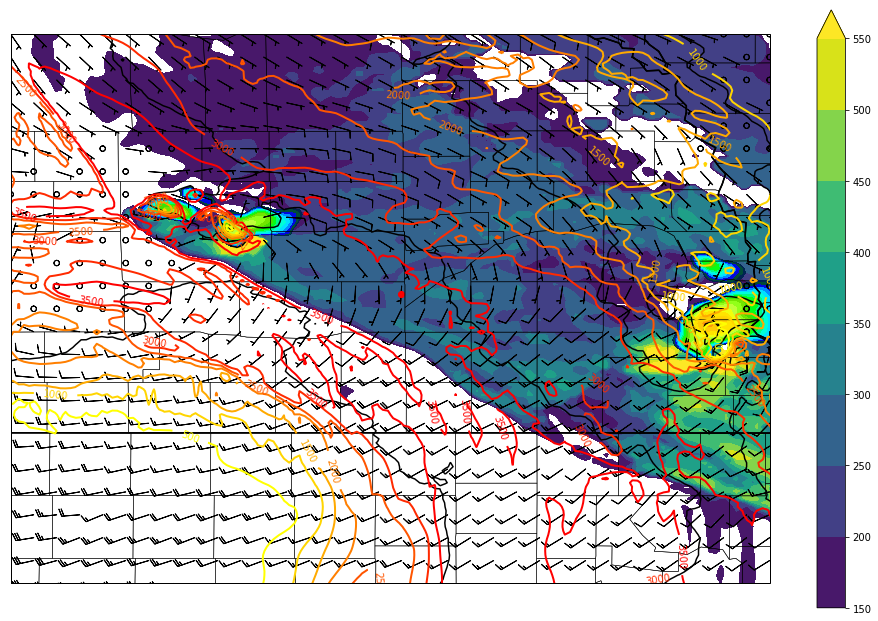

In [129]:
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    hlev = np.arange(150, 600, 50)
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,70,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,psrhe[:,:],hlev,cmap=plt.cm.viridis, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=25)
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    #plt.savefig('wrfplot_ReadingDayhel'+str(FH)+'.png')
    FH = FH+1
plt.show()

In [130]:
sup_comp_def_e = supercell_comp(moocape, psrhe * units('m^2/s^2'), mshr6.to('knots'))

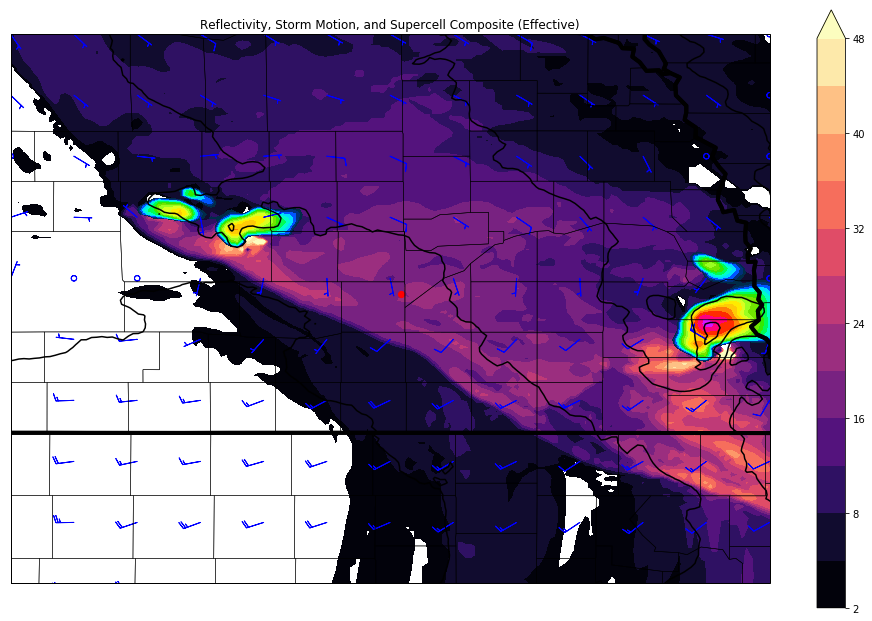

In [131]:
#Plotting supercell composite!!!
FH = 11
for i in range(1):
    
    fig=plt.figure(FH,figsize=(17.,11.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 4)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    SCclev = [2, 4, 8,12,16,20,24,28,32,36,40,44,48]
    plev = np.arange(964,1060,2)
    dbzlev = np.arange(20,60,2)
    cplev = np.arange(500,4000,500)
    #cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    cs = ax.contourf(clons,clats,sup_comp_def_e,SCclev,cmap=plt.cm.magma, extend = "max")
    cp = ax.contour(clons, clats,slp[FH,:,:], plev, linewidths = 1.5, colors = 'k')
    #ca = ax.contour(clons, clats,mcape[0,FH,:,:], cplev, linewidths = 2, cmap = plt.cm.autumn_r)
    cf = ax.contourf(clons,clats,dbz[FH,0,:,:],dbzlev,cmap=plt.cm.gist_ncar)
    #ax.barbs(clons,clats,ushr5,vshr5,length=6,regrid_shape=10, color = 'r')
    ax.barbs(clons,clats,RMu,RMv,length=6,regrid_shape=10, color = 'b')
    ax.scatter(-98.31, 40.96, s = 38, color = 'r')
    plt.colorbar(cs)
    plt.clabel(ca, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
    plt.savefig('wrfplot_SupercellComp.png')
    plt.title("Reflectivity, Storm Motion, and Supercell Composite (Effective)")
    FH = FH+1
plt.show()